In [1]:
import librosa
import torchaudio
import os
from tqdm import tqdm
import random as r
# from sklearn import KMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn
import pickle 
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import librosa
import scipy.signal

def extract_features(audio, sr):
    # Assuming `audio` is a 1D numpy array representing the audio clip
    # and `sr` is the sample rate

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    
    # Spectral Flux
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    spectral_flux = np.diff(onset_env)
    
    # Spectral Flatness
    spectral_flatness = librosa.feature.spectral_flatness(y=audio)
    
    # CQT for Harmonic Analysis
    cqt = np.abs(librosa.cqt(y=audio, sr=sr))
    
    # Spectral Rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    
    # Concatenate all features
    # For simplicity, here we just show placeholders for how these features might be concatenated
    features = np.concatenate([
        np.mean(spectral_centroid, axis=1),  # Mean spectral centroid
        spectral_flux,  # Spectral flux as is, may require further processing
        np.mean(spectral_flatness, axis=1),  # Mean spectral flatness
        np.mean(cqt, axis=1),  # Mean across CQT bins
        np.mean(spectral_rolloff, axis=1),  # Mean spectral rolloff
        # lpc_coeffs  # Placeholder for LPC coefficients, needs correct calculation
    ])
    
    return features

In [3]:
path = "../data/rendered_audio/rendered_audio/"
files = os.listdir(path)
r.shuffle(files)
fs = []
embeddings = []

for file in tqdm(files):
    if ".flac" in file:
        try:
            full_path = path + file
            audio, _ = torchaudio.load(full_path)
            audio_2 = audio.squeeze(0).numpy()
            features = extract_features(audio_2, 44100)
            embeddings.append(features)
            fs.append(full_path)
        except Exception as e:
            print("error", e)
            


 46%|█████████████████████████████████████████████████████████████████▉                                                                              | 12417/27131 [17:03<16:07, 15.21it/s]

error Error opening '../data/rendered_audio/rendered_audio/d270f326-a3f6-4807-ac06-8716c9166ad1.flac': Format not recognised.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27131/27131 [36:30<00:00, 12.39it/s]


In [4]:
emb = [e.flatten() for e in embeddings]

In [5]:
pca = PCA(n_components=3, svd_solver='full')
pca_ = pca.fit_transform(emb)

In [6]:
kmean_model = KMeans(n_clusters=11).fit(emb)

C:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [7]:
labels = kmean_model.predict(emb)

In [15]:
feature_a = []
feature_b = []
feature_c = []
spec_cent = []
spec_flux = []
spec_flat = []
mean_cqt  = []
spec_rolloff = []

for i in pca_:
    feature_a.append(i[0])
    feature_b.append(i[1])
    feature_c.append(i[2])

for i in emb:
    spec_cent.append(i[0])
    spec_flux.append(i[1])
    spec_flat.append(i[2])
    mean_cqt.append(i[3])
    spec_rolloff.append(i[4])

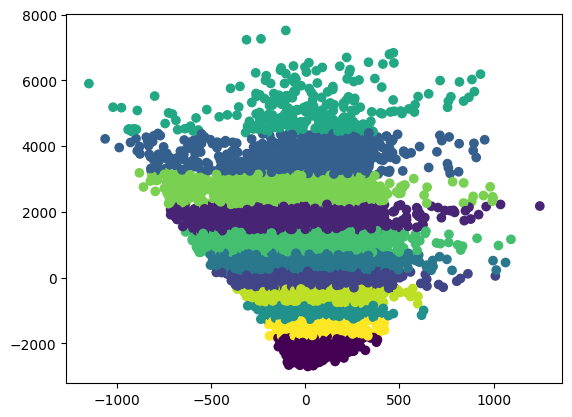

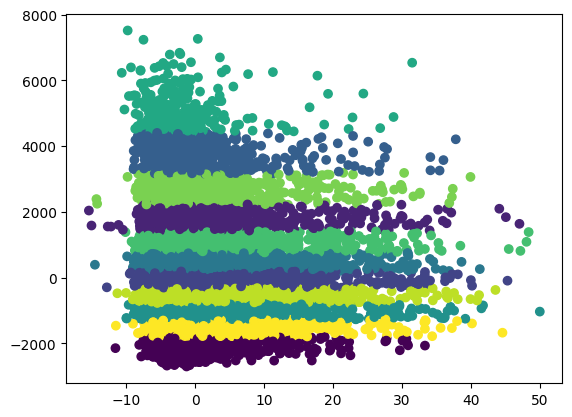

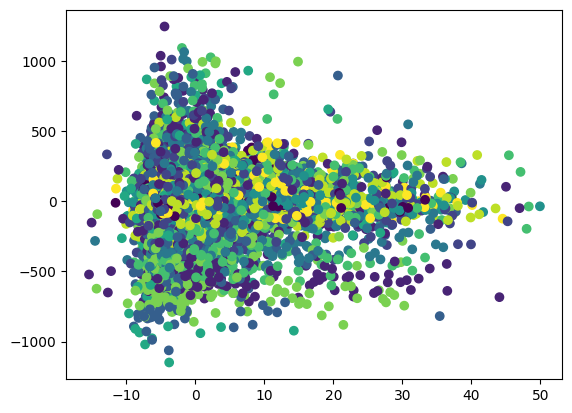

In [9]:
plots = [feature_a, feature_b, feature_c]#, feature_d, feature_e]

for idx, val in enumerate(plots):
    for idx1, val1 in enumerate(plots):
        if idx > idx1:
            #plotting the results
            plt.scatter(val, val1, c=labels)
            plt.show()

In [16]:
import pandas as pd

df = pd.DataFrame()
df['filename'] = fs
df['cluster_label'] = labels
df['pca_feature_a'] = feature_a
df['pca_feature_b'] = feature_b
df['pca_feature_c'] = feature_c

df['spec_cent'] = spec_cent
df['spec_flux'] = spec_flux
df['spec_flat'] = spec_flat
df['mean_cqt'] = mean_cqt
df['spec_rolloff'] = spec_rolloff


In [19]:
df.to_csv('../data/audio_features.csv')
df


filename  cluster_label  \
0      ../data/rendered_audio/rendered_audio/59a5157d...              2   
1      ../data/rendered_audio/rendered_audio/3c179d8d...              2   
2      ../data/rendered_audio/rendered_audio/76a2d5d6...              8   
3      ../data/rendered_audio/rendered_audio/5eb1e014...              9   
4      ../data/rendered_audio/rendered_audio/89e4e83c...              9   
...                                                  ...            ...   
27124  ../data/rendered_audio/rendered_audio/7219f845...              4   
27125  ../data/rendered_audio/rendered_audio/5525b73e...              9   
27126  ../data/rendered_audio/rendered_audio/bc112fd0...              9   
27127  ../data/rendered_audio/rendered_audio/b108dac9...              1   
27128  ../data/rendered_audio/rendered_audio/a27540c8...              3   

       pca_feature_a  pca_feature_b  pca_feature_c    spec_cent  spec_flux  \
0        -247.276162     -82.529263       0.511224  1437.192736        0.0   
1        -266.196496     -75.313029      -0.143404  1434.613677        0.0   
2        2486.922145     -33.124986      -3.682842  2772.378776        0.0   
3        -436.311547      44.508247      -1.610398  1459.857367        0.0   
4        -365.352067     -76.601337      -3.694376  1386.634346        0.0   
...              ...            ...            ...          ...        ...   
27124     708.296953      21.406135      -5.781772  1980.210043        0.0   
27125    -500.144371      92.292347       3.057695  1471.822381        0.0   
27126    -347.229084     -22.908016      -2.655749  1442.521571        0.0   
27127    2108.890735     352.687618      -5.043669  2933.842272        0.0   
27128    4061.090263     -70.400973      -5.057707  3483.166793        0.0   

       spec_flat  mean_cqt  spec_rolloff  
0            0.0  8.470649      0.218492  
1            0.0  7.108098     -2.526043  
2            0.0  4.781816     -1.496236  
3            0.0  5.784354     -1.756250  
4            0.0  3.066963     -2.204909  
...          ...       ...           ...  
27124        0.0  1.904158     -0.635831  
27125        0.0  9.326640     -4.436898  
27126        0.0  4.861183     -0.988139  
27127        0.0  3.612184     -0.020993  
27128        0.0  4.717414     -0.111135  

[27129 rows x 10 columns]

In [12]:
import plotly.graph_objs as go
import plotly.offline as py

import pandas as pd
import numpy as np
from ipywidgets import interactive, HBox, VBox

py.init_notebook_mode()

f = go.FigureWidget([go.Scatter3d(x = df['pca_feature_a'], y = df['pca_feature_b'], z=df['pca_feature_c'])])
scatter = f.data[0]
N = len(df)
scatter.x = scatter.x + np.random.rand(N)/10 *(df['pca_feature_a'].max() - df['pca_feature_a'].min())
scatter.y = scatter.y + np.random.rand(N)/10 *(df['pca_feature_b'].max() - df['pca_feature_b'].min())
scatter.z = scatter.z + np.random.rand(N)/10 *(df['pca_feature_c'].max() - df['pca_feature_c'].min())
scatter.marker.opacity = 0.5

def update_axes(xaxis, yaxis, zaxis):
    scatter = f.data[0]
    scatter.x = df[xaxis]
    scatter.y = df[yaxis]
    scatter.z = df[zaxis]
    with f.batch_update():
        f.layout.xaxis.title = xaxis
        f.layout.yaxis.title = yaxis
        f.layout.zaxis.title = zaxis
        scatter.x = scatter.x + np.random.rand(N)/10 *(df[xaxis].max() - df[xaxis].min())
        scatter.y = scatter.y + np.random.rand(N)/10 *(df[yaxis].max() - df[yaxis].min())
        scatter.z = scatter.y + np.random.rand(N)/10 *(df[yaxis].max() - df[yaxis].min())

axis_dropdowns = interactive(update_axes, xaxis = df.select_dtypes('int64').columns, yaxis = df.select_dtypes('int64').columns,  zaxis = df.select_dtypes('int64').columns)

# Create a table FigureWidget that updates on selection from points in the scatter plot of f
t = go.FigureWidget([go.Table(
    header=dict(values=['pca_feature_a','pca_feature_b','pca_feature_c'],
                fill = dict(color='#C2D4FF'),
                align = ['left'] * 5),
    cells=dict(values=[df[col] for col in ['pca_feature_a','pca_feature_b','pca_feature_c']],
               fill = dict(color='#F5F8FF'),
               align = ['left'] * 5))])

def selection_fn(trace,points,selector):
    t.data[0].cells.values = [df.loc[points.point_inds][col] for col in ['pca_feature_a','pca_feature_b','pca_feature_c']]

scatter.on_selection(selection_fn)

# Put everything together
VBox((HBox(axis_dropdowns.children),f,t))

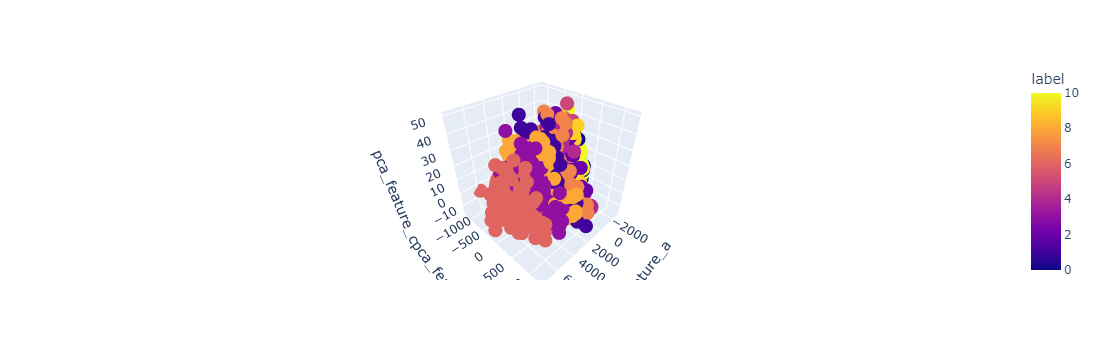

In [13]:
import plotly.express as px
fig = px.scatter_3d(df, x='pca_feature_a', y='pca_feature_b', z='pca_feature_c',
              color='label')
fig.show()
